# Advanced Wind Turbine Simulation Workflow

* A more advanced turbine workflow will include many steps (Which have been showcased in previous examples)
* The process exemplified here includes:
  1. Weather data extraction from a MERRA dataset (windspeed, pressure, temperature)
  2. Spatial adjustment of the windspeeds
  3. Vertical projection of the wind speeds
  4. Wind speed density correction
  5. Power curve convolution
  6. Capacity Factor Estimation

In [1]:
import reskit as rk

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Simulate a Single Location

In [2]:
# Set some constants for later

TURBINE_CAPACITY = 4200 # kW
TURBINE_HUB_HEIGHT = 120 # meters
TURBINE_ROTOR_DIAMETER = 136 # meters
TURBINE_LOCATION = (6.0,50.5) # (lon, lat)

In [3]:
# 1. Create a weather source, load, and extract weather variables
src = rk.weather.MerraSource(rk.TEST_DATA["merra-like"], bounds=[5,49,7,52], verbose=False)

src.sload_elevated_wind_speed()
src.sload_surface_pressure()
src.sload_surface_air_temperature()

raw_windspeeds = src.get("elevated_wind_speed", locations=TURBINE_LOCATION, interpolation='bilinear')
raw_pressure = src.get("surface_pressure", locations=TURBINE_LOCATION, interpolation='bilinear')
raw_temperature = src.get("surface_air_temperature", locations=TURBINE_LOCATION, interpolation='bilinear')

print(raw_windspeeds.head())

2015-01-01 00:30:00+00:00    5.383743
2015-01-01 01:30:00+00:00    5.323299
2015-01-01 02:30:00+00:00    5.232418
2015-01-01 03:30:00+00:00    5.160997
2015-01-01 04:30:00+00:00    5.439261
Name: (6.00000,50.50000), dtype: float64


In [4]:
# 2. Vertically project wind speeds to hub height

roughness = rk.wind.roughness_from_clc(
    clc_path=rk.TEST_DATA['clc-aachen_clipped.tif'],
    loc=TURBINE_LOCATION)


projected_windspeed = rk.wind.apply_logarithmic_profile_projection(
    measured_wind_speed=raw_windspeeds,
    measured_height=50, # The MERRA dataset offers windspeeds at 50m
    target_height=TURBINE_HUB_HEIGHT,
    roughness=roughness)

print(projected_windspeed.head())

2015-01-01 00:30:00+00:00    6.506035
2015-01-01 01:30:00+00:00    6.432992
2015-01-01 02:30:00+00:00    6.323166
2015-01-01 03:30:00+00:00    6.236856
2015-01-01 04:30:00+00:00    6.573127
Name: (6.00000,50.50000), dtype: float64


In [5]:
# 3. Apply density correction

pressure_corrected_windspeeds = rk.wind.apply_air_density_adjustment(
    wind_speed=projected_windspeed,
    pressure=raw_pressure,
    temperature=raw_temperature,
    height=TURBINE_HUB_HEIGHT)

pressure_corrected_windspeeds.head()

2015-01-01 00:30:00+00:00    6.560702
2015-01-01 01:30:00+00:00    6.485689
2015-01-01 02:30:00+00:00    6.374120
2015-01-01 03:30:00+00:00    6.287352
2015-01-01 04:30:00+00:00    6.626462
Name: (6.00000,50.50000), dtype: float64

In [6]:
# 4. Power curve estimation and convolution

power_curve = rk.wind.PowerCurve.from_capacity_and_rotor_diam(
    capacity=TURBINE_CAPACITY, 
    rotor_diam=TURBINE_ROTOR_DIAMETER)

convoluted_power_curve = power_curve.convolute_by_gaussian(scaling=0.06, base=0.1)

In [7]:
# 5. Capacity factor estimation
capacity_factors = convoluted_power_curve.simulate(wind_speed=pressure_corrected_windspeeds)

capacity_factors

array([0.27274368, 0.263165  , 0.24927993, 0.23877819, 0.28130338,
       0.38840787, 0.46432296, 0.50710632, 0.55521966, 0.49867967,
       0.57162601, 0.71241609, 0.70553725, 0.61188673, 0.70550303,
       0.91619617, 0.98435169, 0.9890905 , 0.99523578, 0.99879707,
       0.9995636 , 0.9998783 , 0.99996854, 0.99999167, 0.99999645,
       0.99999847, 0.99999942, 0.99999979, 0.99999986, 0.99999955,
       0.99999584, 0.99996655, 0.99986612, 0.9983592 , 0.99781337,
       0.98068508, 0.94692514, 0.97451119, 0.97225159, 0.97975114,
       0.97173012, 0.93896518, 0.87912222, 0.82910516, 0.78503793,
       0.73948156, 0.63274194, 0.60786955, 0.56240585, 0.49214385,
       0.48403557, 0.55132721, 0.66612623, 0.71490129, 0.71632635,
       0.77203224, 0.83448196, 0.76762935, 0.5640216 , 0.42807353,
       0.41320701, 0.41236897, 0.3295354 , 0.23965176, 0.13568902,
       0.12705538, 0.32104052, 0.49466017, 0.2651354 , 0.20026743,
       0.37168761])

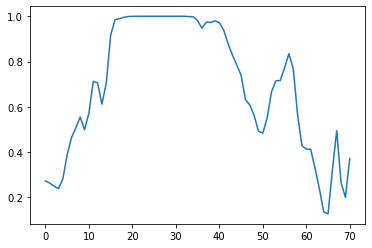

In [8]:
plt.plot(capacity_factors)
plt.show()

# Simulate multiple locations at once (recommended)

In [9]:
TURBINE_CAPACITY = 4200 # kW
TURBINE_HUB_HEIGHT = 120 # meters
TURBINE_ROTOR_DIAMETER = 136 # meters
TURBINE_LOCATION = np.array([(6.25,51.), (6.50,51.), (6.25,50.75)]) # (lon,lat)


# 1
raw_windspeeds = src.get("elevated_wind_speed", locations=TURBINE_LOCATION, interpolation='bilinear')
raw_pressure = src.get("surface_pressure", locations=TURBINE_LOCATION, interpolation='bilinear')
raw_temperature = src.get("surface_air_temperature", locations=TURBINE_LOCATION, interpolation='bilinear')

# 2
roughness = rk.wind.roughness_from_clc(
    clc_path=rk.TEST_DATA['clc-aachen_clipped.tif'],
    loc=TURBINE_LOCATION)


projected_windspeed = rk.wind.apply_logarithmic_profile_projection(
    measured_wind_speed=raw_windspeeds,
    measured_height=50, # The MERRA dataset offers windspeeds at 50m
    target_height=TURBINE_HUB_HEIGHT,
    roughness=roughness)

# 3
pressure_corrected_windspeeds = rk.wind.apply_air_density_adjustment(
    wind_speed=projected_windspeed,
    pressure=raw_pressure,
    temperature=raw_temperature,
    height=TURBINE_HUB_HEIGHT)

convoluted_power_curve = power_curve.convolute_by_gaussian(scaling=0.06, base=0.1)

# 4
power_curve = rk.wind.PowerCurve.from_capacity_and_rotor_diam(
    capacity=TURBINE_CAPACITY, 
    rotor_diam=TURBINE_ROTOR_DIAMETER)

# 5
capacity_factors = convoluted_power_curve.simulate(wind_speed=pressure_corrected_windspeeds)


# Print result
capacity_factors

,"(6.25000,51.00000)","(6.50000,51.00000)","(6.25000,50.75000)"
2015-01-01 00:30:00+00:00,0.395640,0.265962,0.271250
2015-01-01 01:30:00+00:00,0.401436,0.266026,0.263652
2015-01-01 02:30:00+00:00,0.392426,0.262146,0.248813
2015-01-01 03:30:00+00:00,0.355555,0.242029,0.227116
2015-01-01 04:30:00+00:00,0.371413,0.259005,0.247643
...,...,...,...
2015-01-03 18:30:00+00:00,0.050942,0.006590,0.116420
2015-01-03 19:30:00+00:00,0.068628,0.054896,0.204335
2015-01-03 20:30:00+00:00,0.174991,0.163077,0.207437
2015-01-03 21:30:00+00:00,0.335069,0.337246,0.250523


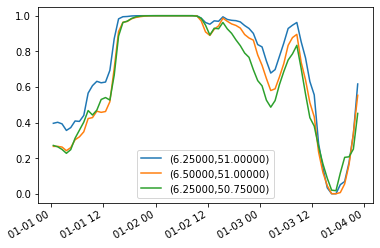

In [10]:
capacity_factors.plot()
plt.show()